<h2 style="text-align: center; padding: 0px">BSc Computer Science Final Project<h2>

<h3 style="text-align: center">Investigating the effectiveness of deep learning in the prediction of precipitation<h3>

<h5 style="text-align: center">Cameron F. T Pope<h5>

<h5 style="text-align: center">University of London<h5>

<h2>Section 1 - Introduction<h2>

The goal of this notebook is to investigate and analyse the effectiveness of deep neural networks in predicting the chance of rainfall occuring on subsequent days based on observations the day prior. The deep neural network will be compared against more traditional machine learning models such as support vector machines (SVMs) and random forests (RFs). This will allow us to draw insight into whwhatether deep learning is more or less suited to this task than these other models. 

These results will also be compared against the professional standard in weather forecasting, where we will attempt to determine whether any of these machine learning techniques have the potential to be used in precipitation forecasting - either standalone, or as a supplimentary model to professional forecasting techniques.

The data used throughout the course of the notebook comes courtesy of the National Oceanic and Atmosphere Administration's (NOAA) daily summaries which is publicly available for download through their climate data search tool found [here](https://www.ncdc.noaa.gov/cdo-web/search).

The data itself comes from the weather station at The Ohio State University Airport in Columbus, OH and contains weather observations dating 01/11/1997 to present day at time of downloading - 03/07/2022. 

The location was chosen somewhat at random, however I wanted to pick somewhere with strong seasonal weather shifts and notoriously short-term weather variations. The data from the OSU Airport also had data dating back 25 years with a high degree of data coverage compared to surrounding weather stations.

<h2>Section 2 - Data Cleaning<h2>

Import libraries required throughout the notebook.

In [1]:
import pandas as pd #For dataframe to store our data
import numpy as np #For linear algebra and numerical processing
import matplotlib.pyplot as plt #For plotting visualisations
import seaborn as sns #For plotting visualisations

from sklearn.preprocessing import StandardScaler #For normalising data
from sklearn.model_selection import train_test_split #For splitting the data into training and testing data
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import GridSearchCV #For searching for optimal hyperparameters
from sklearn.model_selection import RandomizedSearchCV #For searching for optimal hyperparameters

from sklearn.linear_model import LogisticRegression #Logistic Regression model
from sklearn.ensemble import RandomForestClassifier #Random Forest model
from sklearn.svm import SVC #SVM model

import tensorflow as tf
from tensorflow import keras #For creating the neural networks
from tensorflow.keras import layers, models

from imblearn.over_sampling import SMOTE #For oversampling the data

import scipy as sp

Import the data from the csv file, storing it in a pandas dataframe 'df'.

In [2]:
df = pd.read_csv('data.csv')

Set the printing option for pandas columns. This will stop columns being truncated if they do not fit in the notebook, allowing all columns to be seen via a scroll bar.

In [3]:
pd.options.display.max_columns = None

View the fist 5 records in the dataframe. We can see that most data points have no values. In fact, the first 150 records contain only 'TMAX' (maximum temperature) and 'TMIN' (minimum temperature) observations.

In [4]:
df.head()

,STATION,NAME,DATE,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT09
0,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",01/11/1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.3,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",02/11/1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",03/11/1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",04/11/1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",05/11/1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.9,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove the first 150 records in the dataframe

In [5]:
df = df[150:]
df.head()

,STATION,NAME,DATE,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT09
150,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",01/04/1998,5.3,1257.0,1536.0,8.1,NaN,NaN,12.8,16.7,8.9,NaN,200.0,220.0,12.5,14.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",02/04/1998,4.8,31.0,30.0,0.0,NaN,NaN,8.9,12.8,4.4,NaN,270.0,270.0,11.2,13.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",03/04/1998,3.8,2057.0,2057.0,0.5,NaN,NaN,6.7,12.2,0.6,NaN,20.0,10.0,10.7,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",04/04/1998,6.8,1029.0,917.0,0.5,NaN,NaN,5.0,8.9,0.6,NaN,10.0,360.0,11.6,15.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,USW00004804,"COLUMBUS OHIO STATE UNIVERSITY AIRPORT, OH US",05/04/1998,2.6,1546.0,1545.0,0.0,NaN,NaN,5.6,13.3,-2.8,NaN,310.0,320.0,6.7,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Show the number of non-null entries and data type for each column. We can see we have a few features with very few non-null entires, so we will go ahead and remove these from the dataframe.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8852 entries, 150 to 9001
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  8852 non-null   object 
 1   NAME     8852 non-null   object 
 2   DATE     8852 non-null   object 
 3   AWND     8838 non-null   float64
 4   FMTM     2825 non-null   float64
 5   PGTM     7311 non-null   float64
 6   PRCP     8840 non-null   float64
 7   SNOW     1 non-null      float64
 8   SNWD     3 non-null      float64
 9   TAVG     2661 non-null   float64
 10  TMAX     8829 non-null   float64
 11  TMIN     8829 non-null   float64
 12  TSUN     270 non-null    float64
 13  WDF2     8845 non-null   float64
 14  WDF5     8845 non-null   float64
 15  WSF2     8845 non-null   float64
 16  WSF5     8845 non-null   float64
 17  WT01     2518 non-null   float64
 18  WT02     295 non-null    float64
 19  WT03     426 non-null    float64
 20  WT04     5 non-null      float64
 21  WT06     24 

Show some basic statistical metrics about the dataset including the mean and quartiles.

In [7]:
df.describe()

,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT09
count,8838.000000,2825.000000,7311.000000,8840.000000,1.0,3.0,2661.000000,8829.000000,8829.000000,270.0,8845.000000,8845.000000,8845.000000,8845.000000,2518.0,295.0,426.0,5.0,24.0,1353.0,1.0
mean,3.533220,1431.119646,1379.607441,2.573281,0.0,0.0,11.880271,17.083373,6.276034,0.0,214.737140,214.861504,8.125517,10.481651,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,1.546983,524.688577,522.653888,6.553109,NaN,0.0,9.997840,11.054263,9.795665,0.0,96.661898,95.432290,2.785987,3.762043,0.0,0.0,0.0,0.0,0.0,0.0,NaN
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-17.800000,-16.000000,-25.500000,0.0,10.000000,10.000000,2.700000,2.700000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,2.400000,1224.000000,1158.500000,0.000000,0.0,0.0,4.400000,8.300000,-1.000000,0.0,160.000000,160.000000,6.300000,7.600000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,3.400000,1508.000000,1435.000000,0.000000,0.0,0.0,13.300000,18.900000,6.700000,0.0,230.000000,230.000000,7.600000,9.800000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,4.500000,1723.000000,1649.500000,1.300000,0.0,0.0,20.600000,26.700000,14.400000,0.0,290.000000,290.000000,9.800000,12.500000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,11.000000,2359.000000,2359.000000,74.200000,0.0,0.0,29.400000,37.800000,25.000000,0.0,360.000000,360.000000,24.100000,37.100000,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Remove features that have a large majority of missing values, as these are not feasible to accurately fill.

In [8]:
remove_cols = ['FMTM', 'SNOW', 'SNWD', 'TSUN']
df.drop(remove_cols, axis='columns', inplace=True)

We will also remove the station code and name as all data is from the same weather station, so differentiating between stations is not required.

In [9]:
df.drop(['STATION', 'NAME'], axis='columns', inplace=True)

Verify that dropped features have been removed.

In [10]:
df.columns

Index(['DATE', 'AWND', 'PGTM', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5',
       'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08', 'WT09'],
      dtype='object')

Notice how we did not drop some features with a high number of null entries. Why is this? TAVG (average temperature) for example has over 6,000 null entries, but we have left it in. This is because we can create estimates for the missing values based on the TMAX and TMIN (maximum and minumum temperature respectively) by finding the average of these values. This will give a decently accurate estimation for the average temperature for that observation period.

We also left in the WT features (WT01-WT09). If we look at the documentation that accompanies the data [here](https://www.ncei.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf), we can see these values refer to the weather type. For example, WT03 refers to thunder, while WT05 refers to hail. These are 1-hot encoded in the dataframe, with a value of 1 meaning that weather type was observed during the observation period, with a null value meaning these conditions were not observed. For these we can simply fill in the null values with 0's, allowing us to keep these features. 

First we need to fix our index as we removed the first 150 samples, so currently our first sample is index 151. We are going to make the date the index, but first we want to convert it to a pandas Timestamp object. The following 2 cells converts the DATE column to a Timestamp object, prints the data type of the first date to check the conversion was successful, and then sets the DATE column as the index

In [11]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%d/%m/%Y')
type(df['DATE'][151])

pandas._libs.tslibs.timestamps.Timestamp

As we can see, the date has sucessfully been reassigned to the index of the dataframe.

In [12]:
df.set_index('DATE', inplace=True)
df.index

DatetimeIndex(['1998-04-01', '1998-04-02', '1998-04-03', '1998-04-04',
               '1998-04-05', '1998-04-06', '1998-04-07', '1998-04-08',
               '1998-04-09', '1998-04-10',
               ...
               '2022-06-24', '2022-06-25', '2022-06-26', '2022-06-27',
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-02', '2022-07-03'],
              dtype='datetime64[ns]', name='DATE', length=8852, freq=None)

<h4>Filling Missing Values</h4>

Here we are filling in the missing values in the TAVG column. We can use the built in fillna method to fill these values with anything we want. In this case, we get the value in the TMAX and TMIN column at that index, and get the average. This is then assigned to the missing value in the TAVG column.

In [13]:
df['TAVG'].fillna((df['TMAX'] + df['TMIN'])/2, inplace=True)

We have gone from 2661 non-NA values to 8829, but that still leaves us with 23 NA values This is because this method relies on values being present in both the TMAX and TMIN columns for that sample. If one or both of these values are missing, we cannot calculate the average, and as such the NaN value in the TAVG column remains.

In [14]:

print(f"TAVG NA Values: {sum(df['TAVG'].isna())} \nTAVG non-NA Values: {sum(df['TAVG'].notna())}")

TAVG NA Values: 23 
TAVG non-NA Values: 8829


We will fill in these last NA values for the TAVG feature using interpolation. This will take the mean of the previous and next known values in the TAVG column in relation to the missing value and use that mean value to fill the missing value. This is essentially a very localised mean, which is important as we want to preserve yearly, seasonal, or sub-seasonal trends. If we simply filled in the remaining values with the mean or median for the entire dataset, this can lead to local anomalies where the filled value is far above or below the surrounding data, which could also corrupt the data around it - the models can end up drawing wrong conclusions about the weather based on large temperature shifts which weren't actually observed. 

This is also based on the reasoning that a given days temperature is closely related to the previous and subsequent days temperature. While this isn't always true, it does give us a large degree of confidence that our fill method is close to the true value a high percentage of the time. We then verify we have no remaining NA values in the TAVG column.

In [15]:
df['TAVG'] = df['TAVG'].interpolate(method='time')
sum(df['TAVG'].isna())

0

We will also use the same reasoning and method to fill the small number of missing values in the TMAX and TMIN columns. 

We have specified a method of 'time' for the interpolation in the previous cell, as well at the one below. This ensures the interpolation takes into account the actual time of the observation using the index, not just the position of the observation in the dataframe. This means should there be a day missing, for example, the interpolation will take this into account when calculating a fill value as it is now treated as a time series.

In [16]:
df['TMIN'] = df['TMIN'].interpolate(method='time')
df['TMAX'] = df['TMAX'].interpolate(method='time')
print(f"TMIN NA Values: {sum(df['TMIN'].isna())} \nTMAX NA Values: {sum(df['TMAX'].isna())}")

TMIN NA Values: 0 
TMAX NA Values: 0


We will also rename the features to be more desciptive to the values they represent. This is simply for readability purposes.

In [17]:
col_names = ['Avg Wind Speed (m/s)', 'Peak Gust Time (HHMM)', 'Precipitation (mm)', 'TAVG', 'TMAX', 'TMIN', 'Wind Dir. 2m Gust', 'Wind Dir. 5s Gust', 'Fastest 2m Wind Speed (m/s)', 'Fastest 5s Wind Speed (m/s)', 'Fog', 'Heavy Fog', 'Thunder', 'Sleet/Small hail', 'Glaze', 'Smoke/Haze', 'Drifting Snow']
df.columns = col_names

Verify new feature names have been assigned.

In [18]:
df.columns

Index(['Avg Wind Speed (m/s)', 'Peak Gust Time (HHMM)', 'Precipitation (mm)',
       'TAVG', 'TMAX', 'TMIN', 'Wind Dir. 2m Gust', 'Wind Dir. 5s Gust',
       'Fastest 2m Wind Speed (m/s)', 'Fastest 5s Wind Speed (m/s)', 'Fog',
       'Heavy Fog', 'Thunder', 'Sleet/Small hail', 'Glaze', 'Smoke/Haze',
       'Drifting Snow'],
      dtype='object')

Check how many NA values we have left to fill for each feature.

In [19]:
df.isna().sum()

Avg Wind Speed (m/s)             14
Peak Gust Time (HHMM)          1541
Precipitation (mm)               12
TAVG                              0
TMAX                              0
TMIN                              0
Wind Dir. 2m Gust                 7
Wind Dir. 5s Gust                 7
Fastest 2m Wind Speed (m/s)       7
Fastest 5s Wind Speed (m/s)       7
Fog                            6334
Heavy Fog                      8557
Thunder                        8426
Sleet/Small hail               8847
Glaze                          8828
Smoke/Haze                     7499
Drifting Snow                  8851
dtype: int64

Next we'll deal with the missing values for Average Wind Speed. We only have 14 missing values here, however our method of filling those is tricky. As we can see from the boxplot below, we have quite a few outliers which are skewing our mean - showed by the green triangle. There isn't a huge difference here between mean and median, however the median here would be a better metric to fill with due to its resilience to outliers.

The distplot also demonstrates this. Although resembling a normal distribution, there is a clear positive skew.

Our other method - interpolation - also would not be suitable here. This is due to the erratic relationship between average wind speed and time. The line plot below shows the first 200 average windspeed observations in the dataset. We can see large variations in average windspeed in consecutive observations. Essentially, neighbouring observations have little to no relation to eachother in regards to average wind speed.

Interpolation uses these neighbouring observations to inform the missing value, but as we discussed these values do not correlate to the missing value.

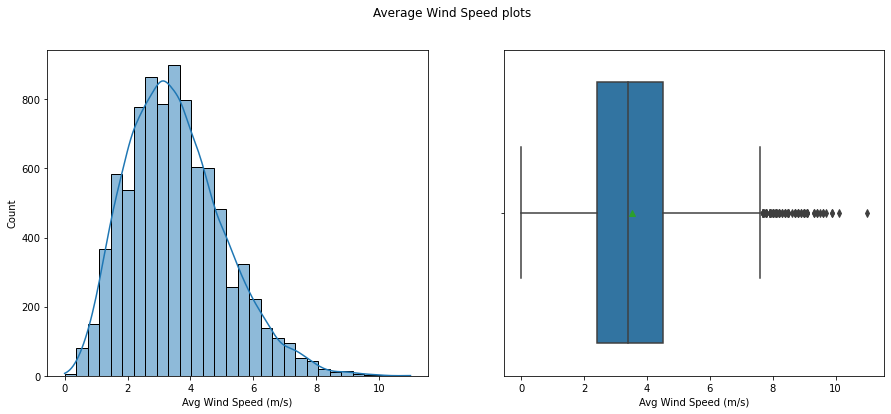

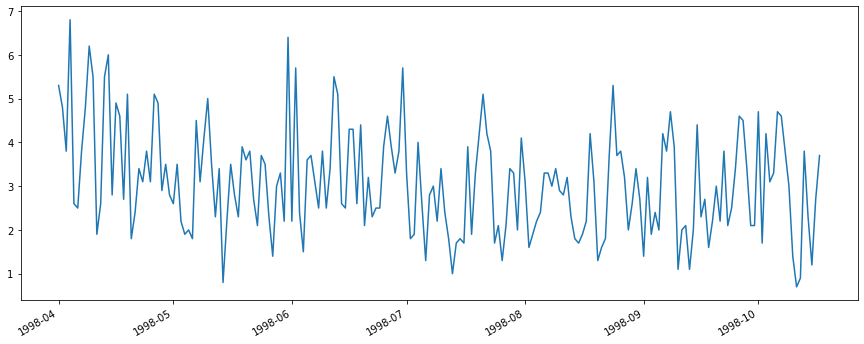

<Figure size 864x432 with 0 Axes>

In [20]:
#First plot for the boxplot and distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig.suptitle('Average Wind Speed plots')

sns.histplot(ax=axes[0], x=df['Avg Wind Speed (m/s)'], bins=30, kde=True)
sns.boxplot(ax=axes[1], x=df['Avg Wind Speed (m/s)'], showmeans=True)


#Second plot for the linegraph
fig, ax = plt.subplots(figsize=(15, 6))
plt.figure(figsize=(12,6))
ax.plot(df['Avg Wind Speed (m/s)'][:200], marker='', linestyle='-')

fig.autofmt_xdate()

We can prove the skew by using scipy to calculate a numerical value of the skew for us.

In [21]:
from scipy.stats import skew

In [22]:
skew(df['Avg Wind Speed (m/s)'])

nan

Due to this, we will use the median as the fill method. This also has its drawbacks, however in this situation it is more suitable than the alternatives.

The cell below fills the missing values with the median, then verifies no NA values remain.

In [23]:
df['Avg Wind Speed (m/s)'].fillna(df['Avg Wind Speed (m/s)'].median(), inplace=True)
df['Avg Wind Speed (m/s)'].isna().sum()

0

Next we will deal with the missing values in peak gust time. This is the time of the day where the peak gust was recorded. Due to this, we have measurements spanning from 0 (midnight) to 2359. This gives us a large range and many outliers, as shown by the boxplot.

The graphs below show the boxplot and distribution plots for the data. From the distribtuion we can see that most of the peak gust times are in the middle part of the day, with the largest number recorded around 15:00. We can see the mean from the boxplot above is also around 15:00, so the median would be a decent guess for filling missing values.

Peak gust time also suffers from a similar problem to the average wind speed above, which is that there is little relation between consecutive days' data, which is shown by the line graph below the distribution and boxplot, so interpolation would also not be useful here. Theres not really a way to get an accurate guess for a fill value, but the median seems like the best bet with a large proportion of recorded values close by to the median.

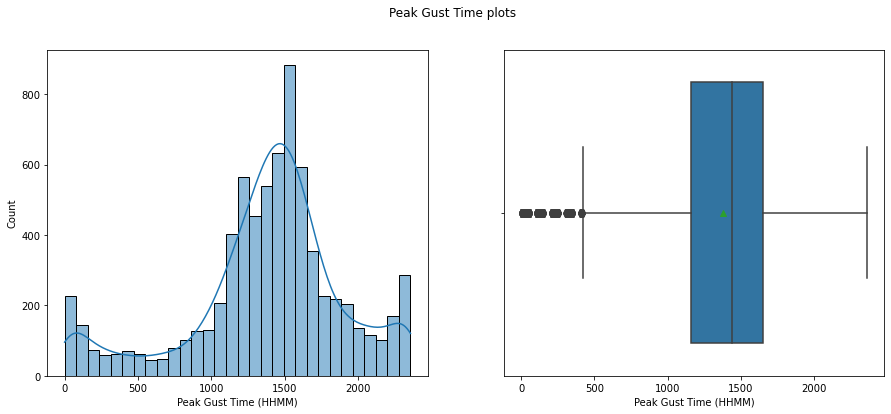

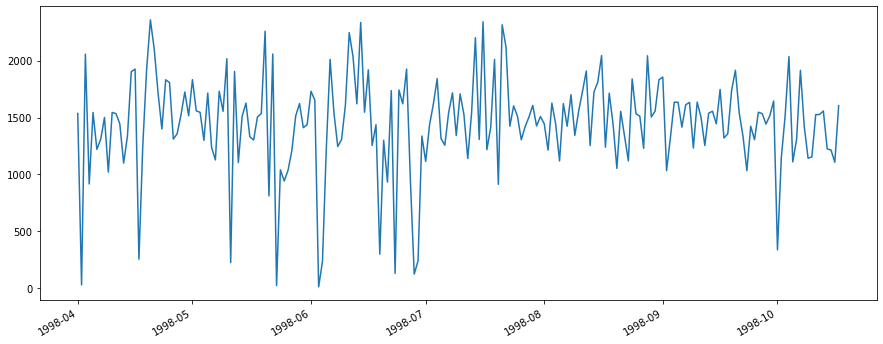

<Figure size 864x432 with 0 Axes>

In [24]:
#First plot for the boxplot and distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig.suptitle('Peak Gust Time plots')

sns.histplot(ax=axes[0], x=df['Peak Gust Time (HHMM)'], bins=30, kde=True)
sns.boxplot(ax=axes[1], x=df['Peak Gust Time (HHMM)'], showmeans=True)


#Second plot for the linegraph
fig, ax = plt.subplots(figsize=(15, 6))
plt.figure(figsize=(12,6))
ax.plot(df['Peak Gust Time (HHMM)'][:200], marker='', linestyle='-')

fig.autofmt_xdate()

Fill missing values in the Peak Gust time column with the median, and verify no NA values remain.

In [25]:
df['Peak Gust Time (HHMM)'].fillna(df['Peak Gust Time (HHMM)'].median(), inplace=True)
df['Peak Gust Time (HHMM)'].isna().sum()

0

Next we will deal with the missing values for wind direction and fastest wind speed. Each of these are only missing 7 values. For the wind direction of the fastest 2 minute and 5 second gust data, the data is in the form of the degrees bearing of the wind gust. Therefore we have data ranging all the way from 0 degrees to 359 degrees. We have no outliers here, although the range does span the entire 360 degree window.

We can see the 2 minute and 5 second gust plots are largely very similar. The fill method I have chosen here is the mean, due to the mean being closer to the central point of the data and the mean not being affected by extreme outliers. We will fill both features with the same method.

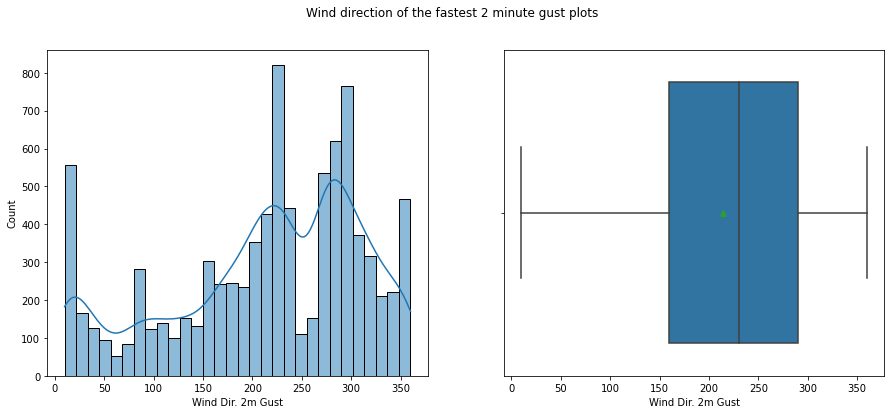

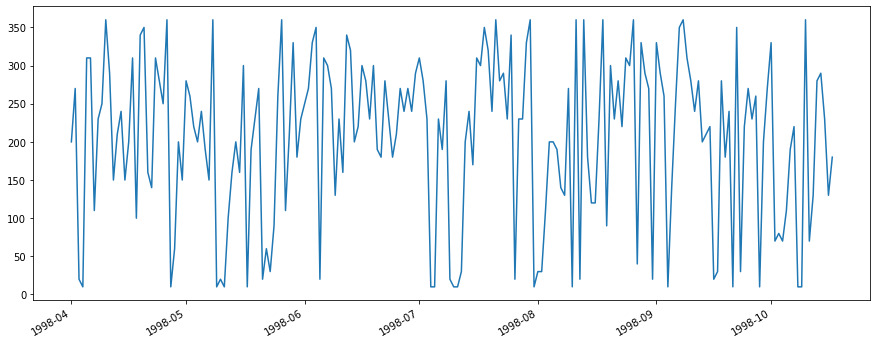

<Figure size 864x432 with 0 Axes>

In [26]:
#First plot for the boxplot and distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig.suptitle('Wind direction of the fastest 2 minute gust plots')

sns.histplot(ax=axes[0], x=df['Wind Dir. 2m Gust'], bins=30, kde=True)
sns.boxplot(ax=axes[1], x=df['Wind Dir. 2m Gust'], showmeans=True)


#Second plot for the linegraph
fig, ax = plt.subplots(figsize=(15, 6))
plt.figure(figsize=(12,6))
ax.plot(df['Wind Dir. 2m Gust'][:200], marker='', linestyle='-')

fig.autofmt_xdate()

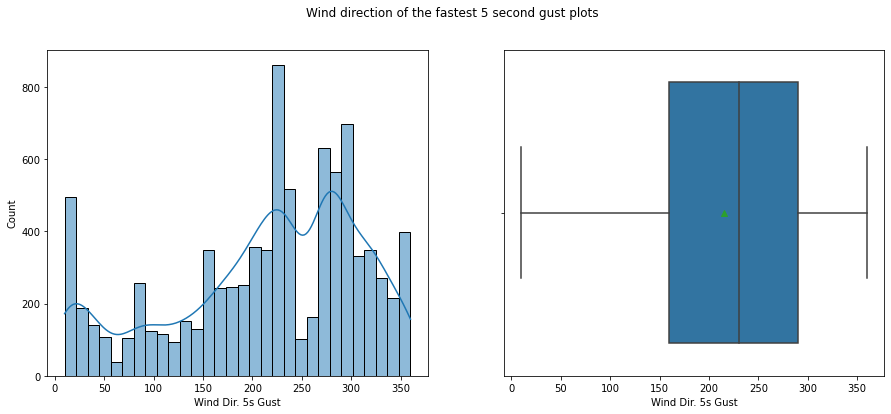

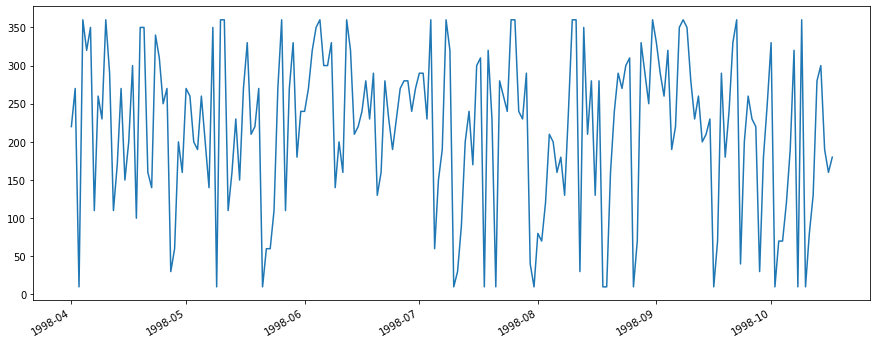

<Figure size 864x432 with 0 Axes>

In [27]:
#First plot for the boxplot and distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig.suptitle('Wind direction of the fastest 5 second gust plots')

sns.histplot(ax=axes[0], x=df['Wind Dir. 5s Gust'], bins=30, kde=True)
sns.boxplot(ax=axes[1], x=df['Wind Dir. 5s Gust'], showmeans=True)


#Second plot for the linegraph
fig, ax = plt.subplots(figsize=(15, 6))
plt.figure(figsize=(12,6))
ax.plot(df['Wind Dir. 5s Gust'][:200], marker='', linestyle='-')

fig.autofmt_xdate()

Fill missing values in the Wind Dir. 2m Gust and Wind Dir. 5s Gust columns with the mean of each respective feature, and verify that no NA values remain.

In [28]:
df['Wind Dir. 2m Gust'].fillna(df['Wind Dir. 2m Gust'].mean(), inplace=True)
df['Wind Dir. 5s Gust'].fillna(df['Wind Dir. 5s Gust'].mean(), inplace=True)

print(f"Wind Dir. 2m Gust NA values: {df['Wind Dir. 2m Gust'].isna().sum()}")
print(f"Wind Dir. 5s Gust NA values: {df['Wind Dir. 5s Gust'].isna().sum()}")

Wind Dir. 2m Gust NA values: 0
Wind Dir. 5s Gust NA values: 0


For the fastest 2 minute and 5 second wind speeds we will return to using the median to fill missing values. We have quite a few outliers again and a positive skew to the data. Interpolation would not be suitable again for the same reasons mentioned before about the erratic and unpredictable nature of consecutive observations.

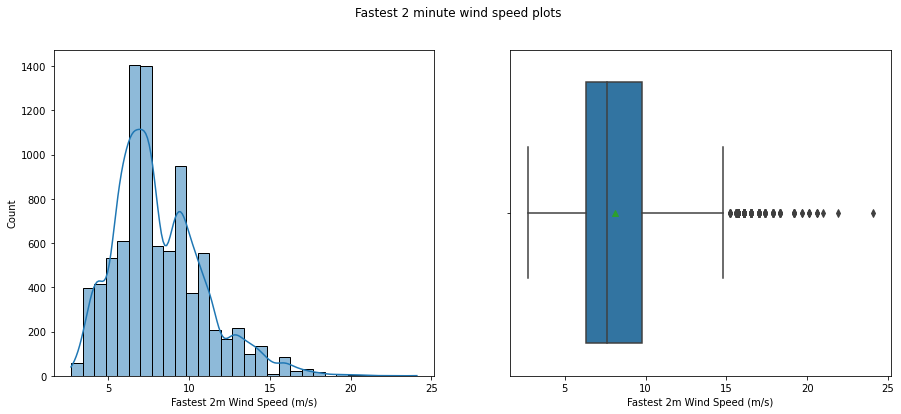

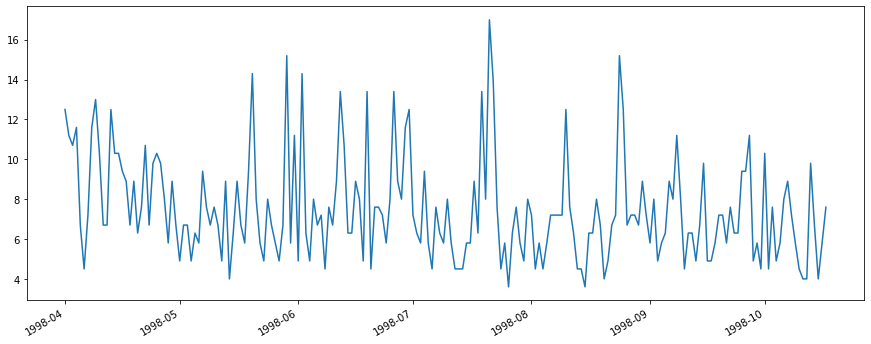

<Figure size 864x432 with 0 Axes>

In [29]:
#First plot for the boxplot and distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig.suptitle('Fastest 2 minute wind speed plots')

sns.histplot(ax=axes[0], x=df['Fastest 2m Wind Speed (m/s)'], bins=30, kde=True)
sns.boxplot(ax=axes[1], x=df['Fastest 2m Wind Speed (m/s)'], showmeans=True)


#Second plot for the linegraph
fig, ax = plt.subplots(figsize=(15, 6))
plt.figure(figsize=(12,6))
ax.plot(df['Fastest 2m Wind Speed (m/s)'][:200], marker='', linestyle='-')

fig.autofmt_xdate()

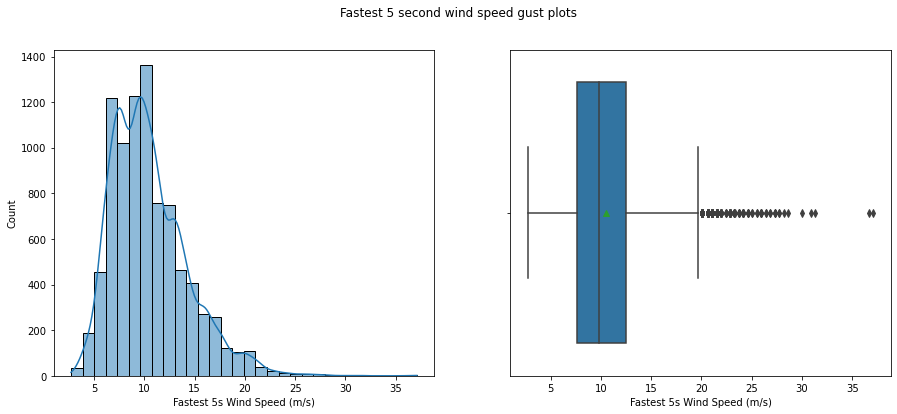

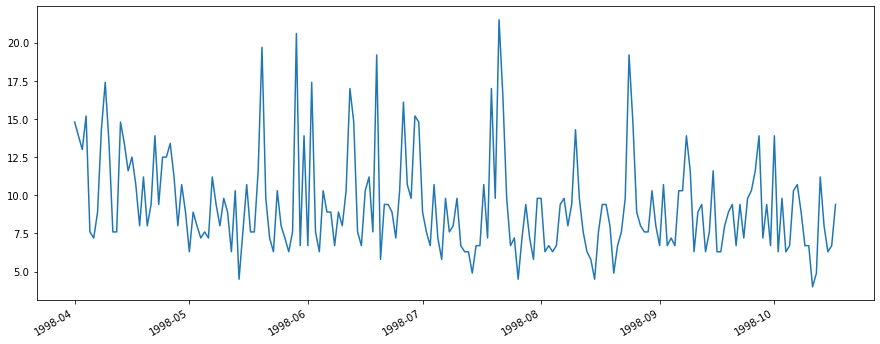

<Figure size 864x432 with 0 Axes>

In [30]:
#First plot for the boxplot and distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig.suptitle('Fastest 5 second wind speed gust plots')

sns.histplot(ax=axes[0], x=df['Fastest 5s Wind Speed (m/s)'], bins=30, kde=True)
sns.boxplot(ax=axes[1], x=df['Fastest 5s Wind Speed (m/s)'], showmeans=True)


#Second plot for the linegraph
fig, ax = plt.subplots(figsize=(15, 6))
plt.figure(figsize=(12,6))
ax.plot(df['Fastest 5s Wind Speed (m/s)'][:200], marker='', linestyle='-')

fig.autofmt_xdate()

Fill the Fastest 2m Wind Speed and Fastest 5s Wind Speed columns with the median of each respective feature, and verify that no NA values remain.

In [31]:
df['Fastest 2m Wind Speed (m/s)'].fillna(df['Fastest 2m Wind Speed (m/s)'].median(), inplace=True)
df['Fastest 5s Wind Speed (m/s)'].fillna(df['Fastest 5s Wind Speed (m/s)'].median(), inplace=True)

print(f"Fastest 2m Wind Speed (m/s) NA values: {df['Fastest 2m Wind Speed (m/s)'].isna().sum()}")
print(f"Fastest 5s Wind Speed (m/s) NA values: {df['Fastest 5s Wind Speed (m/s)'].isna().sum()}")

Fastest 2m Wind Speed (m/s) NA values: 0
Fastest 5s Wind Speed (m/s) NA values: 0


Now we are left with precipitation and the weather types. As discussed previously, the weather types are one hot encoded where the NA values are days where that weather type was not observed. As such all we need to do here is fill all of the NA values with 0's.

In [32]:
df.isna().sum()

Avg Wind Speed (m/s)              0
Peak Gust Time (HHMM)             0
Precipitation (mm)               12
TAVG                              0
TMAX                              0
TMIN                              0
Wind Dir. 2m Gust                 0
Wind Dir. 5s Gust                 0
Fastest 2m Wind Speed (m/s)       0
Fastest 5s Wind Speed (m/s)       0
Fog                            6334
Heavy Fog                      8557
Thunder                        8426
Sleet/Small hail               8847
Glaze                          8828
Smoke/Haze                     7499
Drifting Snow                  8851
dtype: int64

Fill all of the NA values in the Weather Type columns with 0's. We do this by creating a list of the column names of the columns we want to fill and use that as a mask over the dataframe. This then selects all of the weather type columns and then we can fill any NA values with 0's. 

In [33]:
fill_cols = ['Fog', 'Heavy Fog', 'Thunder', 'Sleet/Small hail', 'Glaze', 'Smoke/Haze', 'Drifting Snow']
df[fill_cols] = df[fill_cols].fillna(0)

For precipitation we do not want to fill the missing values, instead we are going to remove the samples where precipitation data is missing. This is because this data will end up being our target and as such we do not want to create any guesses. We only want samples where the precipitation amount is present.

In [34]:
df.isna().sum()

Avg Wind Speed (m/s)            0
Peak Gust Time (HHMM)           0
Precipitation (mm)             12
TAVG                            0
TMAX                            0
TMIN                            0
Wind Dir. 2m Gust               0
Wind Dir. 5s Gust               0
Fastest 2m Wind Speed (m/s)     0
Fastest 5s Wind Speed (m/s)     0
Fog                             0
Heavy Fog                       0
Thunder                         0
Sleet/Small hail                0
Glaze                           0
Smoke/Haze                      0
Drifting Snow                   0
dtype: int64

Remove rows where precipitation is null

In [35]:
df = df[~df['Precipitation (mm)'].isnull()]

Verify that no NA values remain in the dataframe.

In [36]:
df.isna().sum()

Avg Wind Speed (m/s)           0
Peak Gust Time (HHMM)          0
Precipitation (mm)             0
TAVG                           0
TMAX                           0
TMIN                           0
Wind Dir. 2m Gust              0
Wind Dir. 5s Gust              0
Fastest 2m Wind Speed (m/s)    0
Fastest 5s Wind Speed (m/s)    0
Fog                            0
Heavy Fog                      0
Thunder                        0
Sleet/Small hail               0
Glaze                          0
Smoke/Haze                     0
Drifting Snow                  0
dtype: int64

<h2>Section 3 - Target Feature Creation</h2>

For this dataset we need to create our own target feature. We want to predict whether it is going to rain tomorrow based on the current observations, but there is no feature at the moment that specifies whether it rains tomorrow or not.

We will create this by duplicating the precipitation column into a column called 'Rain Tomorrow', shifting it up by one such that it is now present in the prior days' observations. We will then encode the values such that a 0 in the Rain Tomorrow column means it does not rain the following day, and a 1 in the Rain Tomorrow column means it does rain the following day.

Duplicate the Precipitation column into a new column, Rain Tomorrow.

In [37]:
df['Rain Tomorrow'] = df['Precipitation (mm)']

In [38]:
df.head()

,Avg Wind Speed (m/s),Peak Gust Time (HHMM),Precipitation (mm),TAVG,TMAX,TMIN,Wind Dir. 2m Gust,Wind Dir. 5s Gust,Fastest 2m Wind Speed (m/s),Fastest 5s Wind Speed (m/s),Fog,Heavy Fog,Thunder,Sleet/Small hail,Glaze,Smoke/Haze,Drifting Snow,Rain Tomorrow
DATE,,,,,,,,,,,,,,,,,,
1998-04-01,5.3,1536.0,8.1,12.8,16.7,8.9,200.0,220.0,12.5,14.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.1
1998-04-02,4.8,30.0,0.0,8.9,12.8,4.4,270.0,270.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-04-03,3.8,2057.0,0.5,6.7,12.2,0.6,20.0,10.0,10.7,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1998-04-04,6.8,917.0,0.5,5.0,8.9,0.6,10.0,360.0,11.6,15.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1998-04-05,2.6,1545.0,0.0,5.6,13.3,-2.8,310.0,320.0,6.7,7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Shift the Rain Tomorrow column up by one. When looking at the head of the dataframe we can now see the contents of Rain Tomorrow contains the amount of rainfall that occurs on the subsequent day.

In [39]:
df['Rain Tomorrow'] = df['Rain Tomorrow'].shift(-1)

In [40]:
df.head()

,Avg Wind Speed (m/s),Peak Gust Time (HHMM),Precipitation (mm),TAVG,TMAX,TMIN,Wind Dir. 2m Gust,Wind Dir. 5s Gust,Fastest 2m Wind Speed (m/s),Fastest 5s Wind Speed (m/s),Fog,Heavy Fog,Thunder,Sleet/Small hail,Glaze,Smoke/Haze,Drifting Snow,Rain Tomorrow
DATE,,,,,,,,,,,,,,,,,,
1998-04-01,5.3,1536.0,8.1,12.8,16.7,8.9,200.0,220.0,12.5,14.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-04-02,4.8,30.0,0.0,8.9,12.8,4.4,270.0,270.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1998-04-03,3.8,2057.0,0.5,6.7,12.2,0.6,20.0,10.0,10.7,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1998-04-04,6.8,917.0,0.5,5.0,8.9,0.6,10.0,360.0,11.6,15.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-04-05,2.6,1545.0,0.0,5.6,13.3,-2.8,310.0,320.0,6.7,7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


If it does rain tomorrow ('Rain Tomorrow' is greater than 0), then set the value of 'Rain Tomorrow' to 1. If it does not rain tomorrow ('Rain Tommorow' is 0), then 'Rain Tomorrow' remains 0. We now have an encoded value for Rain Tomorrow, whereby the value of 'Rain Tomorrow' is either 0 or 1, depending on whether it rains the following day.

In [41]:
df.loc[df['Rain Tomorrow'] != 0, 'Rain Tomorrow'] = 1

Verify the changes have taken effect.

In [42]:
df['Rain Tomorrow'][:10]

DATE
1998-04-01    0.0
1998-04-02    1.0
1998-04-03    1.0
1998-04-04    0.0
1998-04-05    0.0
1998-04-06    1.0
1998-04-07    1.0
1998-04-08    1.0
1998-04-09    1.0
1998-04-10    0.0
Name: Rain Tomorrow, dtype: float64

We also want to normalize our data. This is due to the fact that the scales between different features vary greatly. For example, Peak Gust Time contains values up to 2359, while TMIN has a much smaller scale with most values being single digits, and often times negative. This could lead to models overemphasising the importance of Peak Gust Time when creating seperation between classes due to differences between small and large values for Peak Gust Time overpowering the differences between small and large values for minimum temperature.

Here we are normalising using a standard scaler, which makes the mean of the data 0, and values of -1 and 1 are 1 standard deviation above and below the mean respectively. This reduces the scales of each feature to a similar amount, while retaining statistical features such as outliers and spread (just at a smaller scale).

We do not want to normalise all features either, as some features are one-hot encoded and do not need standardising. So we only select the columns from the dataframe that we want to apply the standardisation to.

In [43]:
cols_to_norm = ['Avg Wind Speed (m/s)', 'Peak Gust Time (HHMM)', 'Precipitation (mm)', 'TAVG', 'TMAX', 'TMIN', 'Wind Dir. 2m Gust', 'Wind Dir. 5s Gust', 'Fastest 2m Wind Speed (m/s)', 'Fastest 5s Wind Speed (m/s)']
df_scaled = df.copy()
df_scaled[cols_to_norm] = StandardScaler().fit_transform(df_scaled[cols_to_norm])

In [44]:
df_scaled

,Avg Wind Speed (m/s),Peak Gust Time (HHMM),Precipitation (mm),TAVG,TMAX,TMIN,Wind Dir. 2m Gust,Wind Dir. 5s Gust,Fastest 2m Wind Speed (m/s),Fastest 5s Wind Speed (m/s),Fog,Heavy Fog,Thunder,Sleet/Small hail,Glaze,Smoke/Haze,Drifting Snow,Rain Tomorrow
DATE,,,,,,,,,,,,,,,,,,
1998-04-01,1.142801,0.308703,0.843421,0.106339,-0.034087,0.268346,-0.152423,0.053902,1.569823,1.147559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-04-02,0.819418,-2.857111,-0.392703,-0.274080,-0.386841,-0.190901,0.571913,0.577923,1.103243,0.908342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1998-04-03,0.172652,1.403914,-0.316399,-0.488676,-0.441111,-0.578710,-2.015001,-2.146985,0.923789,0.669126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1998-04-04,2.112951,-0.992518,-0.316399,-0.654500,-0.739596,-0.578710,-2.118477,1.521160,1.246806,1.253877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-04-05,-0.603468,0.327622,-0.392703,-0.595974,-0.341616,-0.925697,0.985819,1.101943,-0.511841,-0.766172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-29,-1.250235,0.096387,-0.392703,0.945213,1.223167,0.605128,0.468437,0.577923,-0.834858,-0.872490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-30,-0.668145,0.096387,-0.392703,1.242721,1.467382,0.952115,-0.669806,-0.470119,-0.332387,-0.526955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-01,-0.021378,0.096387,-0.392703,1.706052,1.675417,1.686911,1.192773,1.206747,0.277756,0.297012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Here we plot a heatmap based on the correlation of features to one another. We are most interested in 'Rain Tomorrow' here, as this is what we are trying to predict. We can see that actually, many of the features seem to have very low correlation to Rain Tomorrow. However, we have to be very careful about removing seeminly uncorrelated features, as this heatmap only shows linear correlation between features, and features could be correlated in non-linear ways, or correlated through other features. 

<AxesSubplot:>

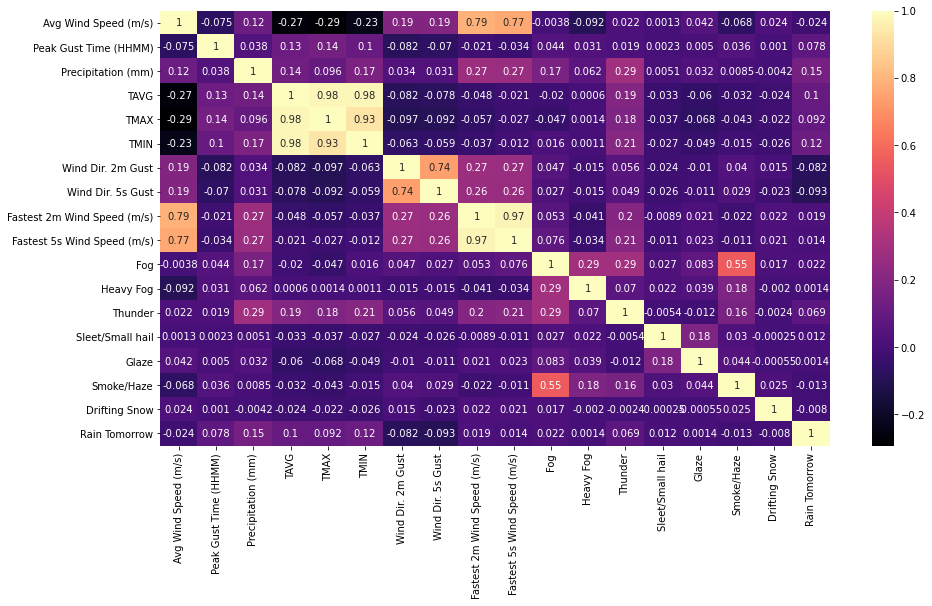

In [45]:
plt.figure(figsize=(15,8))
sns.heatmap(df_scaled.corr(), annot=True, cmap='magma')

Now we can seperate our target from the main dataframe.

In [46]:
target = df_scaled['Rain Tomorrow']
df_scaled.drop('Rain Tomorrow', inplace=True, axis='columns')

Split the main dataframe and target into training and testing data. The main dataframe is split into X_train and X_test, while the target is split into y_train and y_test. A test_size of 0.2 is specified, so 20% of the data is split into the testing sets, with the remaining 80% in the training sets.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, target, test_size=0.2, random_state=40)

In [48]:
X_train

,Avg Wind Speed (m/s),Peak Gust Time (HHMM),Precipitation (mm),TAVG,TMAX,TMIN,Wind Dir. 2m Gust,Wind Dir. 5s Gust,Fastest 2m Wind Speed (m/s),Fastest 5s Wind Speed (m/s),Fog,Heavy Fog,Thunder,Sleet/Small hail,Glaze,Smoke/Haze,Drifting Snow
DATE,,,,,,,,,,,,,,,,,
2021-09-26,0.107975,0.096387,-0.392703,0.511145,0.716648,0.268346,0.261483,0.263510,-0.188824,0.057796,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-03-25,-0.150732,0.069059,-0.392703,0.589180,0.662378,0.492867,-0.462852,-0.470119,-0.655404,-0.633274,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2008-11-02,-1.379588,-2.180224,-0.392703,0.184374,0.164903,0.207113,-1.704571,-1.832572,-1.480892,-1.350922,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2001-01-06,0.884095,0.455852,-0.392703,-1.142217,-1.291341,-0.925697,0.054530,0.158706,-0.188824,-0.048523,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-09-24,-1.702972,0.710210,-0.392703,0.867179,1.015133,0.666361,-0.773282,-0.784531,-1.624455,-1.723037,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-05,-0.603468,0.096387,-0.392703,0.267286,0.562883,-0.068435,-0.773282,-1.203748,-0.978421,-0.766172,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-18,2.242305,1.094901,-0.346921,-1.059305,-0.793866,-1.313506,0.675390,0.682727,2.072294,1.971526,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2014-08-06,-0.603468,0.270864,-0.392703,1.028125,0.969908,1.064375,1.503202,-2.146985,-0.188824,-0.287739,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ensure the length of both training sets and both testing sets are the same

In [49]:
len(X_train) == len(y_train) and len(X_test) == len(y_test)

True

<h2>Section 4 - Baseline Model Creation</h2>

Now that our data is ready, it's time to create some models. In this section, we will be creating baseline models with default hyperparameters for Logistic Regression, Random Forest, and Support Vector Machines. For the neural network, a simple architecture will be used to act as a baseline.

<h3>Logistic Regression</h3>

Create a basic LR model with default hyperparameters. Set a random state so results are repeatable and models are comparable between iterations. Also fit the model to the training data.

In [50]:
lr_model = LogisticRegression(random_state=4)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=4)

Create predictions from the model by passing in the previously unseen testing data. Save these predictions in a new variable, y_pred.

In [51]:
y_pred = lr_model.predict(X_test)

Compare the predicted values to the true values, getting an accuracy score. We can see here the LR model scores 65.7% accuracy, however this isn't the full picture. The dataset is unbalanced, and as such, accuracy is not the best metric to use here.

In [52]:
accuracy_score(y_test, y_pred)

0.6572398190045249

We can see from the confusion matrix that the model does well finding the true values of no-rain, but fails to find the majority of rain instances, mispredicting them as no rain. This suggests the model is overemphasising the no-rain class due to its higher number of class members. 

<AxesSubplot:>

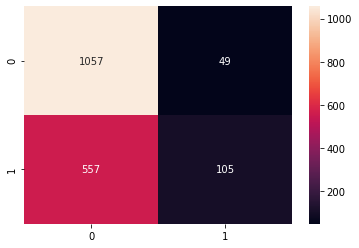

In [53]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

We can also see this numerically. We can see class 0 scored 95.5% recall, while class 1 only scored 15.8%. So while our model scored decently on accuracy, this is actually a poor model. Only 15% of the time can it correctly predict rainfall occuring the next day.

In [54]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.65489467, 0.68181818]),
 array([0.9556962 , 0.15861027]),
 array([0.77720588, 0.25735294]),
 array([1106,  662], dtype=int64))

The classification report shows this in an easier to read manner

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.96      0.78      1106
         1.0       0.68      0.16      0.26       662

    accuracy                           0.66      1768
   macro avg       0.67      0.56      0.52      1768
weighted avg       0.66      0.66      0.58      1768



A better way to evaluate the models would be using f1 score. This calculates the harmonic mean between precision and recall, meaning a model has to perform well in both metrics in order to get a high f1 score. This heavily punishes poor scores. While we got 0.955 recall for class 0, the poor performance in class 1's recall means our f1 score comes out at 0.257

In [56]:
f1_score(y_test, y_pred)

0.2573529411764706

<h3>Random Forest</h3>

As with LR, create and fit a default RF model with set random state.

In [57]:
rf_model = RandomForestClassifier(random_state=4)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=4)

Create predictions from the model

In [58]:
y_pred = rf_model.predict(X_test)

Compare predicted with true values for an accuracy score

In [59]:
accuracy_score(y_test, y_pred)

0.6923076923076923

Create the confusion matrix heatmap. We can see the RF model did not correctly identify as many true values for class 0 and the LR model did, but scored far better in identifying class 1's true values - albeit still less than half of them

<AxesSubplot:>

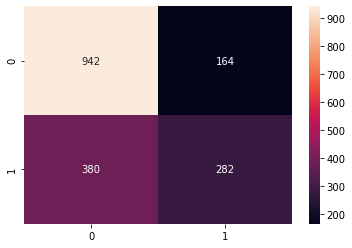

In [60]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [61]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.71255673, 0.632287  ]),
 array([0.8517179 , 0.42598187]),
 array([0.77594728, 0.50902527]),
 array([1106,  662], dtype=int64))

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.85      0.78      1106
         1.0       0.63      0.43      0.51       662

    accuracy                           0.69      1768
   macro avg       0.67      0.64      0.64      1768
weighted avg       0.68      0.69      0.68      1768



Despite the lower performance on class 0, the improved performance on class 1 means the RF model vastly outperforms the LR model in terms of f1 score

In [63]:
f1_score(y_test, y_pred)

0.5090252707581229

<h3>SVM</h3>

Create and fit the default SVM model

In [64]:
svm_model = SVC(random_state=4)
svm_model.fit(X_train, y_train)

SVC(random_state=4)

Create predictions from the model

In [65]:
y_pred = svm_model.predict(X_test)

Compare predicted and true values for an accuracy score

In [66]:
accuracy_score(y_test, y_pred)

0.7007918552036199

Create the confusion matrix. We can see the SVM model slots between the RF and LR models. It performs better at identifying true values for class 0 than RF but worse than LR, and better at predicting class 1 than LR, but worse than RF

<AxesSubplot:>

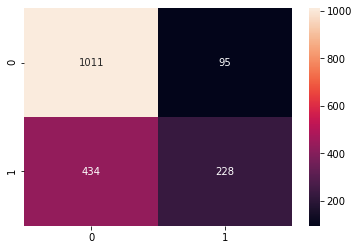

In [67]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [68]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.69965398, 0.70588235]),
 array([0.91410488, 0.34441088]),
 array([0.79263034, 0.46294416]),
 array([1106,  662], dtype=int64))

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.91      0.79      1106
         1.0       0.71      0.34      0.46       662

    accuracy                           0.70      1768
   macro avg       0.70      0.63      0.63      1768
weighted avg       0.70      0.70      0.67      1768



This observation is backed up by the f1 score, which is between that of RF and LR

In [70]:
f1_score(y_test, y_pred)

0.46294416243654823

<h3>Basic Neural Network</h3>

For the neural network, there is no random seed to pass to the model. Instead, we set the global tensorflow random seed. This means we do not need to set this anymore as it will persist throughout all neural network models

In [71]:
tf.random.set_seed(4)

Create a neural network sequential model with 3 hidden dense layers. We use 1 neuron for the output layer as we have a binary classification problem, and this neuron can either activate (for 1), or not activate (for 0). We use a sigmoid activation as this gives us a probability of belonging to a binary class. 

In [72]:
nn_model = models.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

Train the model for 10 epochs, and save the training history

In [73]:
history = nn_model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1)

Epoch 1/10
111/111 [==============================] - 7s 6ms/step - loss: 0.6099 - accuracy: 0.6684 - precision: 0.5972 - recall: 0.2391
Epoch 2/10
111/111 [==============================] - 1s 6ms/step - loss: 0.5873 - accuracy: 0.6927 - precision: 0.6238 - recall: 0.3665
Epoch 3/10
111/111 [==============================] - 1s 5ms/step - loss: 0.5795 - accuracy: 0.7012 - precision: 0.6349 - recall: 0.3980
Epoch 4/10
111/111 [==============================] - 1s 5ms/step - loss: 0.5749 - accuracy: 0.7087 - precision: 0.6420 - recall: 0.4294
Epoch 5/10
111/111 [==============================] - 1s 6ms/step - loss: 0.5708 - accuracy: 0.7090 - precision: 0.6388 - recall: 0.4389
Epoch 6/10
111/111 [==============================] - 1s 5ms/step - loss: 0.5657 - accuracy: 0.7163 - precision: 0.6564 - recall: 0.4432
Epoch 7/10
111/111 [==============================] - 1s 5ms/step - loss: 0.5629 - accuracy: 0.7179 - precision: 0.6529 - recall: 0.4601
Epoch 8/10
111/111 [=====================

The summary allows us to see the model in more detail. We can see this model has over 54000 trainable parameters.

In [74]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4608      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________


Access the history dictionary and pull out each of the metrics

In [75]:
loss = history.history['loss']
acc = history.history['accuracy']
prec = history.history['precision']
rec = history.history['recall']

epochs = range(1, len(loss) + 1)

Plot the accuracy, precision, and recall over the training. We can see while the accuracy is relatively high, both precision and recall are lower than the accuracy, with recall in particular being exceptionally low.

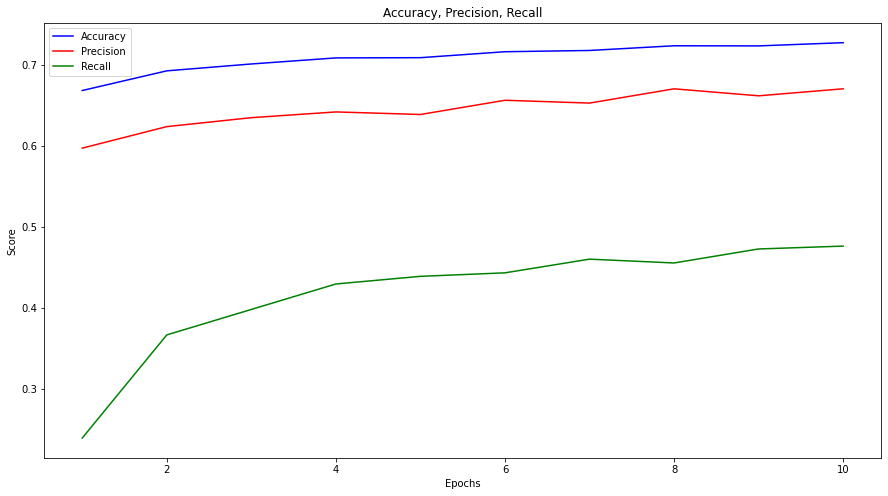

In [76]:
plt.figure(figsize=(15,8))
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.plot(epochs, prec, 'r', label='Precision')
plt.plot(epochs, rec, 'g', label='Recall')

plt.title('Accuracy, Precision, Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

Test the model on unseen data by passing the model the testing data

In [77]:
results = nn_model.evaluate(X_test, y_test)

56/56 [==============================] - 1s 4ms/step - loss: 0.5812 - accuracy: 0.7121 - precision: 0.6409 - recall: 0.5257


Calculate the f1 score of the model on the test set by pulling the precision and recall from the results list, and using them to calculate the f1 score.

In [78]:
precision = results[2]
recall = results[3]
f1score = 2 * (precision * recall) / (precision + recall)
f1score

0.5775933680606856

<h2>Section 5 - Oversampling Data using SMOTE</h2>

Due to the models performing poorly on the minority class, we will use Synthetic Minority Oversampling to equalize the classes. This is done by adding samples to the minority class until there are the same number of samples in each. New samples are created using a KNN algorithm which creates new samples along a linear seperator between neighboring samples.

We can see from the printout below that the dataset contains 3205 samples belonging to class 1, and 5635 samples belonging to class 0.

In [79]:
print(f'Number of days where it rained: {len(df[df["Rain Tomorrow"] ==1])} \nNumber of days where it did not rain: {len(df[df["Rain Tomorrow"] == 0])}')

Number of days where it rained: 3205 
Number of days where it did not rain: 5635


Create an oversampler with a set random state for repeatable results. 
Fit and resample the data using the created oversampler.

In [80]:
oversample = SMOTE(random_state=4)
X, y = oversample.fit_resample(df_scaled, target)

We can see that now there are an equal number of samples in each class.

In [81]:
print(f'Number of days where it rained: {len(y[y == 1])} \nNumber of days where it did not rain: {len(y[y ==0])}')

Number of days where it rained: 5635 
Number of days where it did not rain: 5635


We need to split our data again into training and testing sets. We use the same test size and same random state as we used before when splitting the data.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

<h2>Section 6 - Oversampled Models</h2>

Now that the data has been oversampled, we will recreate the basic models using this new data and observe the difference in performance

<h3>Logistic Regression - Oversampled</h3>

Recreate the same basic LR model as before and fit it to the new oversampled data.

In [83]:
lr_model = LogisticRegression(random_state=4)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=4)

Create predictions from this model

In [84]:
y_pred = lr_model.predict(X_test)

We can see that our accuracy actually decreased from the last iteration of the model. However this does not tell the full story, as our common sense baseline is now 50%, whereas before it was around 66% due to the unbalanced dataset. This actually represents an improvement over the common sense baseline than the previous model.

In [85]:
accuracy_score(y_test, y_pred)

0.5905057675244011

The heatmap shows that the performance on class 1 improved dramatically compared to the previous iteration. The model is now able to correctly identify the majority of each class correctly.

<AxesSubplot:>

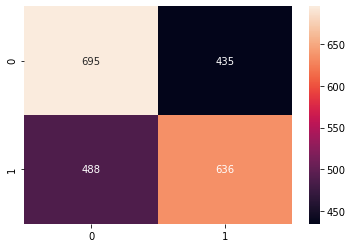

In [86]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60      1130
         1.0       0.59      0.57      0.58      1124

    accuracy                           0.59      2254
   macro avg       0.59      0.59      0.59      2254
weighted avg       0.59      0.59      0.59      2254



The f1 score of this model far outperforms the previous iteration, proving that balancing the dataset has improved performance.

In [88]:
f1_score(y_test, y_pred)

0.579498861047836

<h3>Random Forest - Oversampled</h3>

Recreate the basic RF model and fit the data

In [89]:
rf_model = RandomForestClassifier(random_state=4)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=4)

Create predictions from the model

In [90]:
y_pred = rf_model.predict(X_test)

Compare predicted against true values for an accuracy score

In [91]:
accuracy_score(y_test, y_pred)

0.7568766637089619

Create the heatmap. This shows pretty impressive performance for a default model, performing well on both classes

<AxesSubplot:>

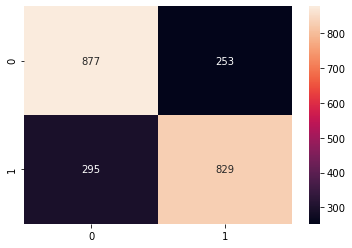

In [92]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [93]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.76      1130
         1.0       0.77      0.74      0.75      1124

    accuracy                           0.76      2254
   macro avg       0.76      0.76      0.76      2254
weighted avg       0.76      0.76      0.76      2254



This impressive performance is further evidenced by the f1 score at 0.751

In [94]:
f1_score(y_test, y_pred)

0.7515865820489575

<h3>SVM - Oversampled</h3>

Create the basic SVM model and fit the data

In [95]:
svm_model = SVC(random_state=4)
svm_model.fit(X_train, y_train)

SVC(random_state=4)

Use the model to create predictions

In [96]:
y_pred = svm_model.predict(X_test)

Compare predicted to true values to get an accuracy score

In [97]:
accuracy_score(y_test, y_pred)

0.6885536823425022

Create the confusion matrix heatmap. Like LR and RF, the performance is now balanced across the two classes, although this model exibits worse performance than the RF model.

<AxesSubplot:>

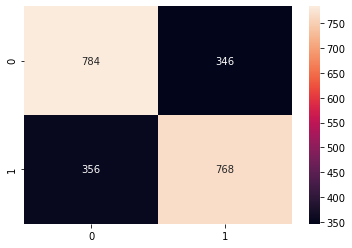

In [98]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      1130
         1.0       0.69      0.68      0.69      1124

    accuracy                           0.69      2254
   macro avg       0.69      0.69      0.69      2254
weighted avg       0.69      0.69      0.69      2254



In [100]:
f1_score(y_test, y_pred)

0.6863270777479893

<h3>Basic Neural Network - Oversampled</h3>

Recreate the same neural network before, with the same architecture, optimizer, loss function etc.

In [101]:
nn_model = models.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

Train the model for the same number of epochs and with the same batch size.

In [102]:
history = nn_model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1)

Epoch 1/10
141/141 [==============================] - 1s 5ms/step - loss: 0.6400 - accuracy: 0.6337 - precision_1: 0.6456 - recall_1: 0.5937
Epoch 2/10
141/141 [==============================] - 1s 5ms/step - loss: 0.6121 - accuracy: 0.6676 - precision_1: 0.6753 - recall_1: 0.6464
Epoch 3/10
141/141 [==============================] - 1s 5ms/step - loss: 0.6043 - accuracy: 0.6766 - precision_1: 0.6817 - recall_1: 0.6633
Epoch 4/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5928 - accuracy: 0.6900 - precision_1: 0.6950 - recall_1: 0.6779
Epoch 5/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5863 - accuracy: 0.6909 - precision_1: 0.6948 - recall_1: 0.6817
Epoch 6/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5801 - accuracy: 0.6943 - precision_1: 0.6989 - recall_1: 0.6834
Epoch 7/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5729 - accuracy: 0.7034 - precision_1: 0.7068 - recall_1: 0.6959
Epoch 8/10
14

In [103]:
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               4608      
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________


Pull out the loss, accuracy, precision and recall from the history dictionary

In [104]:
loss = history.history['loss']
acc = history.history['accuracy']
prec = history.history['precision_1']
rec = history.history['recall_1']

epochs = range(1, len(loss) + 1)

Plot the accuracy, precision, and recall. We can see the improvement of recall specifically compared to the last iteration, where recall was lagging far behind accuracy and precision.

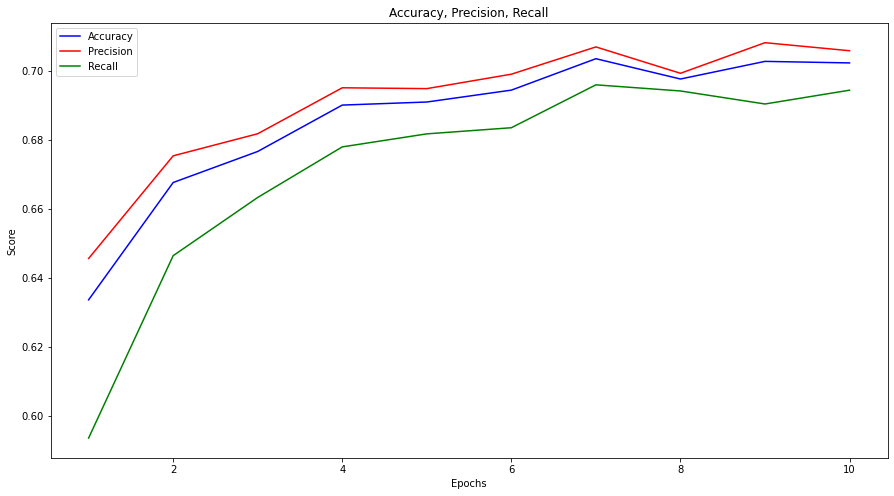

In [105]:
plt.figure(figsize=(15,8))
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.plot(epochs, prec, 'r', label='Precision')
plt.plot(epochs, rec, 'g', label='Recall')

plt.title('Accuracy, Precision, Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

Evaluate the model and calculate the f1 score as we did before. We can also see the f1 score has improved between iterations simply by oversampling the data.

In [106]:
results = nn_model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 4ms/step - loss: 0.6087 - accuracy: 0.6859 - precision_1: 0.6588 - recall_1: 0.7678


In [107]:
precision = results[2]
recall = results[3]
f1score = 2 * (precision * recall) / (precision + recall)
f1score

0.7091207789671004

<h2>Section 7 - Optimising Models</h2>

<h3>Logistic Regression - Optimisation</h3>

For optimising the hyperparameters of the Logistic Regression and Random Forest models, GridSearchCV from scikit learn was used. However, due to the need of occasionally restarting the kernel, and with some of the grid searches taking upwards of an hour to execute each time, the actual outputs of the grid search are not shown. I have left the param_grid which defines the search space, and summarised the best parameters which were obtained by calling grid.best_params_ after the data is fit.

In [108]:
lr_model = LogisticRegression(random_state=4)

Specify the paramter grid. The grid search will then try all combinations of these parameters by creating a new model for each, fitting the data, and then evaluating its performance. The best combination of parameters is then saved so we can access it and train a new model with the best parameters.

In [109]:
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [1e-5, 1e-4, 1e-2, 1e-1, 1, 10, 100]
}

Instantiate the grid search, passing it the model we want to optimize, our paramter grid, and our evalution metric. In this case, the combination of parameters that lead to the best f1 score are saved.

In [110]:
grid = GridSearchCV(lr_model, param_grid, scoring='f1')

Fit the data, which begins the grid search. Once complete, print the best score achieved and the best parameter combination.

In [111]:
#grid.fit(X, y)

#print(grid.best_params_)
#print(grid.best_score_)

#Best params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
#Best score: 0.5951673994477497

Once we have the best parameters we have found during our search, we train the model with those hyperparameters.

In [112]:
lr_model = LogisticRegression(random_state=4, C=0.01, penalty='l1', solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.01, penalty='l1', random_state=4, solver='liblinear')

In [113]:
y_pred = lr_model.predict(X_test)

In [114]:
accuracy_score(y_test, y_pred)

0.5949423247559894

<AxesSubplot:>

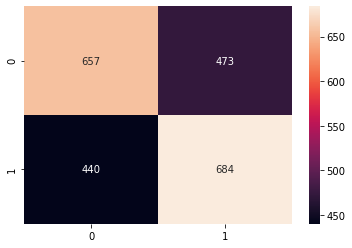

In [115]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.58      0.59      1130
         1.0       0.59      0.61      0.60      1124

    accuracy                           0.59      2254
   macro avg       0.60      0.59      0.59      2254
weighted avg       0.60      0.59      0.59      2254



While this model did perform better than the unoptimized one, the gap between them was small, leading to the assumption we are close to the peak performance for this model. We could specify another grid search in a small area around the optimal parameters to try and find even better ones, but this is likely to lead to an even smaller gain.

In [117]:
f1_score(y_test, y_pred)

0.5997369574747918

<h3>Random Forest - Optimisation</h3>

In [118]:
rf_model = RandomForestClassifier(random_state=4)

Specify the parameter grid for the RF model. RF's have more hyperparameters so we have more combinations to test and more models to create. Fortunately RF models have a good time complexity, scaling logarithmically with input size.

In [119]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [32, 64, 128],
    'max_features': [2, 3, 'sqrt', 'log2', 'auto'],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [2 ,4 ,6, 8],
    'n_estimators': [50, 100, 200, 300, 500]
}

Instantiate the search, passing our model, parameter grid, and scoring as before. This time we will only use 2-fold cross validation instead of the default 5 due to the increased number of models we are created as compared to the LR search.

In [120]:
grid = GridSearchCV(rf_model, param_grid, scoring='f1', verbose=2, cv=2)

In [121]:
#grid.fit(X,y)
#print(grid.best_params_)
#print(grid.best_score_)

#Best params: {'bootstrap': True, 'max_depth': 64, 'max_features': 2, 
#                'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
#Best score: 0.7701863354037267

Train a new model using the best hyperparameters found during the search.

In [122]:
rf_model = RandomForestClassifier(random_state=4, bootstrap=True, max_depth=64, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=64, max_features=2, n_estimators=300,
                       random_state=4)

In [123]:
y_pred = rf_model.predict(X_test)

In [124]:
accuracy_score(y_test, y_pred)

0.7555456965394853

<AxesSubplot:>

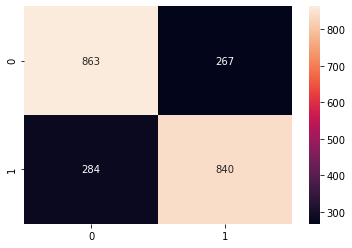

In [125]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.76      0.76      1130
         1.0       0.76      0.75      0.75      1124

    accuracy                           0.76      2254
   macro avg       0.76      0.76      0.76      2254
weighted avg       0.76      0.76      0.76      2254



This model scored fairly well, with over 75% of samples predicted correctly.

In [127]:
f1_score(y_test, y_pred)

0.7530255490811295

<h3>SVM - Optimisation</h3>

We need to take a slightly different approach with tuning the SVM model. Like random forests, SVMs have quite a large search space with many tunable parameters. However, SVM has a poor time complexity of O(n^3) based on a study by Abdiansah and Wardoyo of Sriwijaya and Gadjah Mada univerisities respectively. 

This means conducting a grid search to find optimal parameters is computationally inefficient and takes a substantial amount of time. I attempted to run a grid search still, but after 8 hours on a 8-core CPU, the search was still far from completion.

To remedy this, we will instead utilise a random search. We specify a search space much like a grid search, but we can now specify continious values. The search will then try a specified number of random permutations of parameters, so we can control how long the search takes while maintaining the large search space.

This has a potential benefit of actually finding better parameters than grid search, as the optimal parameters can often be between the 'spaces' of grid search.

In [128]:
svm_model = SVC(random_state=4)

We specify our parameters to seach in a similar way to grid search, but here we can specify continuous values using the scipy function which creates a uniform distribution from 0 up to the scale. 

In [129]:
params = { 
    'C': sp.stats.uniform(scale=100),
    'kernel':['rbf','sigmoid','linear'],
    'gamma': sp.stats.uniform(scale=1)
}

Instantiate the search, passing our model, parameters to be searched, and scoring, like with grid search. Here we also specify n_iter, which determines the number of random combinations to be tested. Due to the randomness, we also use random state for replication of results.

In [130]:
rand_search = RandomizedSearchCV(svm_model, params, n_iter=25, cv=2, scoring='f1', random_state=4, verbose=2)

In [131]:
#rand_search.fit(X, y)
#print(rand_search.best_params_)
#print(rand_search.best_score_)

#Best params: {'C': 43.61466468797977, 'gamma': 0.9489773067815628, 'kernel': 'rbf'}
#Best score: 0.7428154759154589

Train the new model on the best found hyperparameters.

In [132]:
svm_model = SVC(random_state=4, C=43.61466468797977, gamma=0.9489773067815628, kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=43.61466468797977, gamma=0.9489773067815628, random_state=4)

In [133]:
y_pred = svm_model.predict(X_test)

In [134]:
accuracy_score(y_test, y_pred)

0.7604259094942325

<AxesSubplot:>

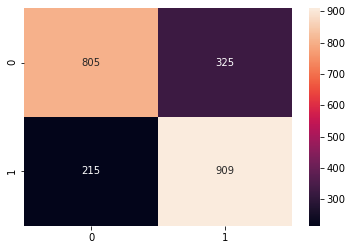

In [135]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75      1130
         1.0       0.74      0.81      0.77      1124

    accuracy                           0.76      2254
   macro avg       0.76      0.76      0.76      2254
weighted avg       0.76      0.76      0.76      2254



Despite only trying 25 different combinations of hyperparameters as compared to the 1000+ of the RF grid search, the SVM model has proven to be the most effective model, with an f1 socre of 0.771

In [137]:
f1_score(y_test, y_pred)

0.7709923664122137

<h3>Neural Network - Optimisation</h3>

For the neural network optimisation process we will be following the Universal Workflow of Machine Learning as outlined by Francois Chollet's book Deep Learning with Python (2017). The 7 steps are:

 1. Defining the problem and assembling the dataset
 2. Choosing a measure of success
 3. Deciding on an evaluation protocol
 4. Preparing your data
 5. Developing a model that does better than a baseline
 6. Scaling up: developing a model that overfits
 7. Regularizing your model and tuning your hyperparameters
 
So far we have achieved much of the first 5 steps. We have obtained our dataset from step 1, we have chosen out measure of success by defining the problem we are trying to solve (deep learning versus other models, and versus industry) from step 2, we have prepared our data from step 4, and developed a model that does better than a baseline from step 5. A baseline in this case is a 'common sense check', whereby we create a model that does better than random guesses. For the case of our upsampled dataset, this is 50% as each class accounts for half of the dataset. Our basic model was able to achieve 68% accuracy - above the required baseline.

One thing we did not consider when creating these basic models is deciding an evaluation protocol from step 3. This step is where we specify how we measure our progress, such as by using K-fold or iterated K-fold cross validation. We have enough data that using either of these is not necessary so we will use a hold-out validation set instead, whereby we take a subset of our training data and use it to test the model after each epoch during training. This allows us to keep our testing set aside for the final test once the model has finished training.

The next step is to scale up and develop a model that overfits. It is during this step we create a more substantial model and train it for longer. We want to model to overfit so we can query the history and find the exact point the model begins to overfit. We can then retrain the model so that training stops at this point where overfitting begins, leaving us with the optimal model.

First, lets set aside our validation set for use during training. We will use train_test_split again for this.

In [138]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=4) 

In [139]:
print(f'Len of X_train: {len(X_train)}, Len of y_train: {len(y_train)}\nlen of X_test: {len(X_test)}, len of y_test: {len(y_test)}\nlen of X_val: {len(X_val)}, len of y_val: {len(y_val)}')

Len of X_train: 7212, Len of y_train: 7212
len of X_test: 2254, len of y_test: 2254
len of X_val: 1804, len of y_val: 1804


Many different architectures were tested here, from varying the number of layers, neurons per layer, adding and removing dropout, varying the degree of dropout etc. While there is no doubt a better architecture for this problem, this was the best one that was found.

In [140]:
nn_model = models.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

Train the model for 100 epochs. We want to ensure the model overfits so we can identify this point and retrain the model for the optimal number of epochs.

In [141]:
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/100
113/113 [==============================] - 2s 9ms/step - loss: 0.6493 - accuracy: 0.6231 - precision_2: 0.6284 - recall_2: 0.6040 - val_loss: 0.6282 - val_accuracy: 0.6563 - val_precision_2: 0.7217 - val_recall_2: 0.5089
Epoch 2/100
113/113 [==============================] - 1s 7ms/step - loss: 0.6285 - accuracy: 0.6564 - precision_2: 0.6699 - recall_2: 0.6179 - val_loss: 0.6078 - val_accuracy: 0.6746 - val_precision_2: 0.6593 - val_recall_2: 0.7228
Epoch 3/100
113/113 [==============================] - 1s 7ms/step - loss: 0.6159 - accuracy: 0.6687 - precision_2: 0.6771 - recall_2: 0.6462 - val_loss: 0.6101 - val_accuracy: 0.6680 - val_precision_2: 0.6409 - val_recall_2: 0.7639
Epoch 4/100
113/113 [==============================] - 1s 7ms/step - loss: 0.6091 - accuracy: 0.6772 - precision_2: 0.6842 - recall_2: 0.6592 - val_loss: 0.5985 - val_accuracy: 0.6785 - val_precision_2: 0.7007 - val_recall_2: 0.6231
Epoch 5/100
113/113 [==============================] - 1s 7ms/step -

113/113 [==============================] - 1s 8ms/step - loss: 0.4974 - accuracy: 0.7493 - precision_2: 0.7625 - recall_2: 0.7249 - val_loss: 0.6128 - val_accuracy: 0.7045 - val_precision_2: 0.7199 - val_recall_2: 0.6696
Epoch 37/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4888 - accuracy: 0.7500 - precision_2: 0.7647 - recall_2: 0.7229 - val_loss: 0.6106 - val_accuracy: 0.6863 - val_precision_2: 0.7159 - val_recall_2: 0.6175
Epoch 38/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4847 - accuracy: 0.7585 - precision_2: 0.7771 - recall_2: 0.7254 - val_loss: 0.6169 - val_accuracy: 0.6962 - val_precision_2: 0.6962 - val_recall_2: 0.6962
Epoch 39/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4815 - accuracy: 0.7580 - precision_2: 0.7681 - recall_2: 0.7398 - val_loss: 0.6277 - val_accuracy: 0.7012 - val_precision_2: 0.6979 - val_recall_2: 0.7095
Epoch 40/100
113/113 [==============================] - 1s 7ms/step - loss: 0

113/113 [==============================] - 1s 8ms/step - loss: 0.3796 - accuracy: 0.8200 - precision_2: 0.8319 - recall_2: 0.8024 - val_loss: 0.7077 - val_accuracy: 0.7012 - val_precision_2: 0.7019 - val_recall_2: 0.6996
Epoch 72/100
113/113 [==============================] - 1s 8ms/step - loss: 0.3687 - accuracy: 0.8254 - precision_2: 0.8414 - recall_2: 0.8024 - val_loss: 0.7418 - val_accuracy: 0.6863 - val_precision_2: 0.6905 - val_recall_2: 0.6752
Epoch 73/100
113/113 [==============================] - 1s 7ms/step - loss: 0.3691 - accuracy: 0.8211 - precision_2: 0.8405 - recall_2: 0.7930 - val_loss: 0.7426 - val_accuracy: 0.7140 - val_precision_2: 0.7140 - val_recall_2: 0.7140
Epoch 74/100
113/113 [==============================] - 1s 7ms/step - loss: 0.3688 - accuracy: 0.8261 - precision_2: 0.8416 - recall_2: 0.8038 - val_loss: 0.7240 - val_accuracy: 0.7167 - val_precision_2: 0.7175 - val_recall_2: 0.7151
Epoch 75/100
113/113 [==============================] - 1s 7ms/step - loss: 0

In [142]:
nn_model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 4ms/step - loss: 0.8050 - accuracy: 0.7196 - precision_2: 0.7162 - recall_2: 0.7251


[0.8049532175064087,
 0.7196095585823059,
 0.7161687016487122,
 0.7250889539718628]

Pull out the loss, accuracy, precision, and recall on both the training and validation data

In [144]:
loss = history.history['loss']
acc = history.history['accuracy']
prec = history.history['precision_2']
rec = history.history['recall_2']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
val_prec = history.history['val_precision_2']
val_rec = history.history['val_recall_2']

epochs = range(1, len(loss) + 1)

Plot the training vs validation loss, and the training vs validation accuracy. We can see the loss begins to rise after about 20 epochs, hoever, the accuracy still slowly trends upwards.

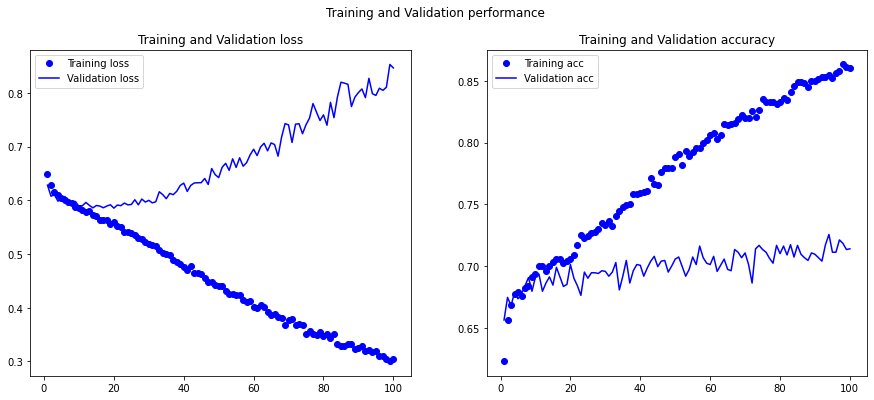

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

fig.suptitle('Training and Validation performance')

axes[0].plot(epochs, loss, 'bo', label='Training loss')
axes[0].plot(epochs, val_loss, 'b', label='Validation loss')
axes[0].title.set_text('Training and Validation loss')
axes[0].legend()

axes[1].plot(epochs, acc, 'bo', label='Training acc')
axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
axes[1].title.set_text('Training and Validation accuracy')
axes[1].legend()

Plot a graph showing the validation accuracy against precision and recall over time.

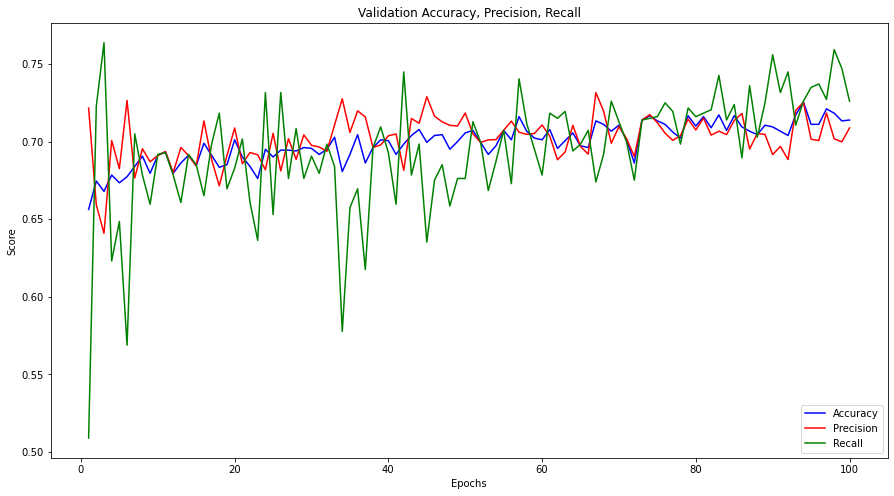

In [146]:
plt.figure(figsize=(15,8))
plt.plot(epochs, val_acc, 'b', label='Accuracy')
plt.plot(epochs, val_prec, 'r', label='Precision')
plt.plot(epochs, val_rec, 'g', label='Recall')

plt.title('Validation Accuracy, Precision, Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

Find the exact epoch with the lowest validation loss, and the exact epoch with the highest validation accuracy

In [147]:
print(f'Epoch with lowest validation loss: {np.argmin(val_loss) + 1}')
print(f'Epoch with highest validation accuracy: {np.argmax(val_acc) + 1}')

Epoch with lowest validation loss: 20
Epoch with highest validation accuracy: 94


Recreate the model from scratch, training it for 94 epochs (highest validation accuracy was observed here)

In [149]:
nn_model = models.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),

    
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

history = nn_model.fit(X_train, y_train, epochs=94, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/94
113/113 [==============================] - 2s 10ms/step - loss: 0.6497 - accuracy: 0.6249 - precision_4: 0.6325 - recall_4: 0.5979 - val_loss: 0.6309 - val_accuracy: 0.6480 - val_precision_4: 0.7143 - val_recall_4: 0.4933
Epoch 2/94
113/113 [==============================] - 1s 7ms/step - loss: 0.6279 - accuracy: 0.6571 - precision_4: 0.6709 - recall_4: 0.6179 - val_loss: 0.6103 - val_accuracy: 0.6696 - val_precision_4: 0.6574 - val_recall_4: 0.7084
Epoch 3/94
113/113 [==============================] - 1s 7ms/step - loss: 0.6181 - accuracy: 0.6682 - precision_4: 0.6761 - recall_4: 0.6467 - val_loss: 0.6079 - val_accuracy: 0.6741 - val_precision_4: 0.6518 - val_recall_4: 0.7472
Epoch 4/94
113/113 [==============================] - 1s 7ms/step - loss: 0.6093 - accuracy: 0.6682 - precision_4: 0.6751 - recall_4: 0.6495 - val_loss: 0.6009 - val_accuracy: 0.6779 - val_precision_4: 0.7009 - val_recall_4: 0.6208
Epoch 5/94
113/113 [==============================] - 1s 7ms/step - los

113/113 [==============================] - 1s 7ms/step - loss: 0.4988 - accuracy: 0.7482 - precision_4: 0.7683 - recall_4: 0.7113 - val_loss: 0.6121 - val_accuracy: 0.7018 - val_precision_4: 0.7156 - val_recall_4: 0.6696
Epoch 37/94
113/113 [==============================] - 1s 8ms/step - loss: 0.4896 - accuracy: 0.7522 - precision_4: 0.7711 - recall_4: 0.7179 - val_loss: 0.6127 - val_accuracy: 0.6840 - val_precision_4: 0.7225 - val_recall_4: 0.5976
Epoch 38/94
113/113 [==============================] - 1s 7ms/step - loss: 0.4850 - accuracy: 0.7519 - precision_4: 0.7683 - recall_4: 0.7221 - val_loss: 0.6348 - val_accuracy: 0.6857 - val_precision_4: 0.6855 - val_recall_4: 0.6863
Epoch 39/94
113/113 [==============================] - 1s 7ms/step - loss: 0.4890 - accuracy: 0.7514 - precision_4: 0.7686 - recall_4: 0.7199 - val_loss: 0.6331 - val_accuracy: 0.6929 - val_precision_4: 0.6946 - val_recall_4: 0.6885
Epoch 40/94
113/113 [==============================] - 1s 7ms/step - loss: 0.480

113/113 [==============================] - 1s 7ms/step - loss: 0.3659 - accuracy: 0.8299 - precision_4: 0.8411 - recall_4: 0.8138 - val_loss: 0.7236 - val_accuracy: 0.6990 - val_precision_4: 0.6962 - val_recall_4: 0.7062
Epoch 72/94
113/113 [==============================] - 1s 7ms/step - loss: 0.3640 - accuracy: 0.8260 - precision_4: 0.8392 - recall_4: 0.8069 - val_loss: 0.7538 - val_accuracy: 0.6984 - val_precision_4: 0.6925 - val_recall_4: 0.7140
Epoch 73/94
113/113 [==============================] - 1s 7ms/step - loss: 0.3687 - accuracy: 0.8207 - precision_4: 0.8366 - recall_4: 0.7975 - val_loss: 0.7718 - val_accuracy: 0.7106 - val_precision_4: 0.7194 - val_recall_4: 0.6907
Epoch 74/94
113/113 [==============================] - 1s 7ms/step - loss: 0.3584 - accuracy: 0.8311 - precision_4: 0.8419 - recall_4: 0.8157 - val_loss: 0.7519 - val_accuracy: 0.7018 - val_precision_4: 0.7198 - val_recall_4: 0.6608
Epoch 75/94
113/113 [==============================] - 1s 7ms/step - loss: 0.356

Observing the printouts from the training, we can see at epoch 90 there is a more optimal model for f1 score as it has a higher precision and recall. Recreate the model again, but only train for 90 epochs this time.

In [150]:
nn_model = models.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),

    
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

history = nn_model.fit(X_train, y_train, epochs=90, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/90
113/113 [==============================] - 2s 9ms/step - loss: 0.6465 - accuracy: 0.6247 - precision_5: 0.6326 - recall_5: 0.5960 - val_loss: 0.6315 - val_accuracy: 0.6458 - val_precision_5: 0.7131 - val_recall_5: 0.4878
Epoch 2/90
113/113 [==============================] - 1s 7ms/step - loss: 0.6259 - accuracy: 0.6600 - precision_5: 0.6754 - recall_5: 0.6173 - val_loss: 0.6055 - val_accuracy: 0.6802 - val_precision_5: 0.6727 - val_recall_5: 0.7018
Epoch 3/90
113/113 [==============================] - 1s 7ms/step - loss: 0.6194 - accuracy: 0.6690 - precision_5: 0.6790 - recall_5: 0.6423 - val_loss: 0.6092 - val_accuracy: 0.6785 - val_precision_5: 0.6575 - val_recall_5: 0.7450
Epoch 4/90
113/113 [==============================] - 1s 7ms/step - loss: 0.6097 - accuracy: 0.6744 - precision_5: 0.6824 - recall_5: 0.6536 - val_loss: 0.6011 - val_accuracy: 0.6741 - val_precision_5: 0.7034 - val_recall_5: 0.6020
Epoch 5/90
113/113 [==============================] - 1s 7ms/step - loss

113/113 [==============================] - 1s 7ms/step - loss: 0.4960 - accuracy: 0.7510 - precision_5: 0.7589 - recall_5: 0.7362 - val_loss: 0.6102 - val_accuracy: 0.6979 - val_precision_5: 0.7059 - val_recall_5: 0.6785
Epoch 37/90
113/113 [==============================] - 1s 6ms/step - loss: 0.4915 - accuracy: 0.7463 - precision_5: 0.7612 - recall_5: 0.7182 - val_loss: 0.6110 - val_accuracy: 0.6608 - val_precision_5: 0.6869 - val_recall_5: 0.5909
Epoch 38/90
113/113 [==============================] - 1s 7ms/step - loss: 0.4838 - accuracy: 0.7594 - precision_5: 0.7745 - recall_5: 0.7326 - val_loss: 0.6439 - val_accuracy: 0.6813 - val_precision_5: 0.6775 - val_recall_5: 0.6918
Epoch 39/90
113/113 [==============================] - 1s 7ms/step - loss: 0.4886 - accuracy: 0.7543 - precision_5: 0.7658 - recall_5: 0.7332 - val_loss: 0.6315 - val_accuracy: 0.6946 - val_precision_5: 0.6961 - val_recall_5: 0.6907
Epoch 40/90
113/113 [==============================] - 1s 7ms/step - loss: 0.478

113/113 [==============================] - 1s 7ms/step - loss: 0.3777 - accuracy: 0.8188 - precision_5: 0.8379 - recall_5: 0.7908 - val_loss: 0.7252 - val_accuracy: 0.7045 - val_precision_5: 0.7066 - val_recall_5: 0.6996
Epoch 72/90
113/113 [==============================] - 1s 7ms/step - loss: 0.3621 - accuracy: 0.8258 - precision_5: 0.8427 - recall_5: 0.8016 - val_loss: 0.7569 - val_accuracy: 0.6846 - val_precision_5: 0.6747 - val_recall_5: 0.7129
Epoch 73/90
113/113 [==============================] - 1s 7ms/step - loss: 0.3642 - accuracy: 0.8275 - precision_5: 0.8455 - recall_5: 0.8019 - val_loss: 0.7483 - val_accuracy: 0.7034 - val_precision_5: 0.7141 - val_recall_5: 0.6785
Epoch 74/90
113/113 [==============================] - 1s 7ms/step - loss: 0.3638 - accuracy: 0.8274 - precision_5: 0.8416 - recall_5: 0.8069 - val_loss: 0.7506 - val_accuracy: 0.7106 - val_precision_5: 0.7097 - val_recall_5: 0.7129
Epoch 75/90
113/113 [==============================] - 1s 7ms/step - loss: 0.355

Evaluate the model on the test set, and calculate the f1 score. While this model performs slightly better than the baseline, the improvement is minor and a much larger network is required. Arguably the baseline model on the oversampled data is a superior model.

In [151]:
results = nn_model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 4ms/step - loss: 0.7800 - accuracy: 0.7161 - precision_5: 0.7086 - recall_5: 0.7313


In [152]:
precision = results[2]
recall = results[3]
f1score = 2 * (precision * recall) / (precision + recall)
f1score

0.719789840279798

<h2>Section 8 - Results</h2>

Add the f1 scores from each model over each iteration to a dictionary

In [153]:
scores = {
          'iteration 1': {'LR': 0.257, 'RF': 0.509, 'SVM': 0.462, 'NN': 0.577}, 
          'iteration 2': {'LR': 0.579, 'RF': 0.751, 'SVM': 0.686, 'NN': 0.709},
          'iteration 3': {'LR': 0.599, 'RF': 0.753, 'SVM': 0.770, 'NN': 0.715}
         }

Convert this dictionary to a dataframe

In [154]:
scores_df = pd.DataFrame(scores)

In [155]:
scores_df

,iteration 1,iteration 2,iteration 3
LR,0.257,0.579,0.599
RF,0.509,0.751,0.753
SVM,0.462,0.686,0.770
NN,0.577,0.709,0.715


Plot a bar graph, showing the performance of each model over the three iterations, and how these compare to each other.

<AxesSubplot:>

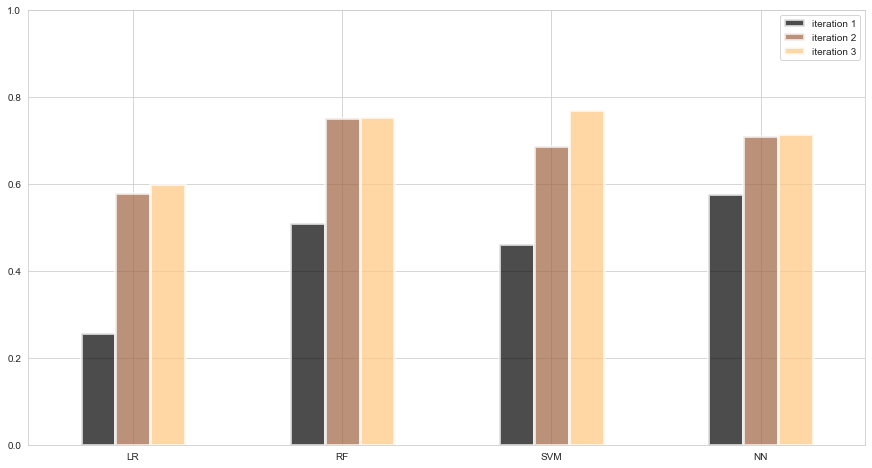

In [156]:
sns.set_style("whitegrid")
scores_df.plot.bar(rot=0, figsize=(15,8), colormap='copper', alpha=0.7, ylim=(0,1), edgecolor='white', linewidth=3)